# Politeness strategies in MT-mediated communication

In this notebook, we demo how to extract politeness strategies using ConvoKit's `PolitenessStrategies` module both in English and in Chinese. We will make use of this functionality to assess the degree to which politeness strategies are preserved in machine-translated texts.

The politeness strategies considered are adapted from operationalizations in the following papers:

- English: [A computational approach to politeness with application to social factors](https://www.cs.cornell.edu/~cristian/Politeness.html), [The politeness Package: Detecting Politeness in Natural Language](https://journal.r-project.org/archive/2018/RJ-2018-079/RJ-2018-079.pdf)

- Chinese: [Studying Politeness across Cultures using English Twitter and Mandarin Weibo](https://dl.acm.org/doi/abs/10.1145/3415190)



In [4]:
import os
from collections import defaultdict, Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import spacy

from convokit import Corpus, Speaker, Utterance, download
from convokit import TextParser, PolitenessStrategies

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# TODO: decide on whether to keep this
# from convokit import TextTranslator

## 1. Preparing diagnostic test sets 

We sample utterances from Wikipedia Talkpages discussions in both English and Chinese. In particular, we use the medium-sized `wiki-corpus` shipped by ConvoKit as the source for sampling English utterances (as shown below), and we sampled a subset of utterances from [WikiConv](https://www.cs.cornell.edu/~cristian/index_files/wikiconv-conversation-corpus.pdf) (Chinese) as shared in [figshare](https://figshare.com/articles/dataset/WikiConv_-_Chinese/7376012). 

The sampled corpora are saved in ConvoKit format as `wiki-en-sampled` and `wiki-zh-sampled`, which can be directly downloaded. We will use these corpora in Part 2 of this notebook to explore how we can assess the permeability of politeness signals in machine-translated communication.

### English data: `wiki-corpus`

The medium-sized Wikipedia dataset is provided by ConvoKit as `wiki-corpus` ([documentation](https://convokit.cornell.edu/documentation/wiki.html)). Note that ConvoKit also offers a more complete collection of Wikipedia Talkpage discussions: [the Cornell Wikiconv Dataset](https://convokit.cornell.edu/documentation/wikiconv.html). We choose to use `wiki-corpus` as it is already sufficiently large for our purpose. 

To load the corpus, see options in the cell below. 

In [1]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# WIKI_ROOT_DIR = download('wiki-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE WIKI-CORPUS IS LOCATED
# WIKI_ROOT_DIR = '<YOUR DIRECTORY>'

corpus = Corpus(filename=WIKI_ROOT_DIR)

# load parses
corpus.load_info('utterance',['parsed'])

In [5]:
# Overall stats of the dataset 
corpus.print_summary_stats()

Number of Speakers: 38462
Number of Utterances: 391294
Number of Conversations: 125292


### Extracting strategies

In the case when the corpus is not dependency parsed, it will need to go through an additional step of parsing, which can be achieved via `TextParser`. See [this demo](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/politeness-strategies/politeness_demo.ipynb) for an example. As the `wiki-corpus` ships with pre-computed dependency parses (which we already loaded as you may notice), we can go straight to politeness strategy extraction. 

Here, we will focus on a set of local strategies, and hence specify that we will want to extract with strategy collection "_politeness_local_". For other available options, refer to the [documentation](https://convokit.cornell.edu/documentation/politenessStrategies.html) for details.

In [5]:
ps_local = PolitenessStrategies(strategy_collection="politeness_local", verbose=100000)

# By default, strategy extraction results are saved under "politeness_strategies". 
corpus = ps_local.transform(corpus, markers=True)

### Strategy prevalance 

We can first take a glimpse over utterance-level strategy prevalence, i.e., proportion of utterances using each politeness strategy. This can be easily done using `summarize()`. 

In [6]:
df_prevalence = ps_local.summarize(corpus)

### Sampling 

To assess permeability of these strategies, we sample 1000 instances for each strategy. The results will be saved to a smaller `wiki-en-sampled` corpus, which may be directly downloaded via ConvoKit. 

In [19]:
# utterance-level strategy uses
df_feat = pd.DataFrame.from_dict({utt.id: utt.meta['politeness_strategies'] for utt in corpus.iter_utterances()}, \
                                 orient='index')

In [51]:
# sampling from least common to most
sorted_strategies = df_prevalence.sort_values().index
sampled_ids, samples = set(), []

for k in sorted_strategies:
    df_sample = df_feat[(~df_feat.index.isin(sampled_ids)) & (df_feat[k]==1)].sample(1000, random_state=42)
    df_sample['strategy'] = k
    samples.append(df_sample[['strategy']])
    sampled_ids.update(df_sample.index)
    
df_en_sample = pd.concat(samples)

In [114]:
# saving as a convokit corpus
for i, info in df_en_sample.itertuples():
    utt = corpus.get_utterance(i)
    utt.add_meta('selected', True)
    utt.add_meta('strategy', info)

# filter only selected utterances
wiki_en_sampled = corpus.filter_utterances_by(lambda utt:'selected' in utt.meta and utt.meta['selected'])

### Translating 

To determine the degree to which politeness markers are perserved in translation, we will make comparisons between original and translated texts. To set it up, we two rounds of translations, forming a English -> Chinese -> English loop, i.e., we first translate the English texts into Chinese, and then translate the Chinese translations back into English. 

We use [EasyNMT](https://github.com/UKPLab/EasyNMT) to perform translations between English and Chinese, using model [Opus-MT](https://github.com/Helsinki-NLP/Opus-MT) from [Helsinki-NLP](https://blogs.helsinki.fi/language-technology/). 

In [68]:
from easynmt import EasyNMT

In [69]:
# texts to be translated
df_utts = wiki_en_sampled.get_utterances_dataframe(exclude_meta=True)

# translation model
model = EasyNMT('opus-mt', cache_folder="/belafonte_sauna/liye_translations/easynmt/")

In [77]:
df_utts['en-zh'] = model.translate(list(df_utts['text']), \
                                   target_lang='zh', \
                                   source_lang='en', \
                                   show_progress_bar=True,
                                   batch_size=8, \
                                   perform_sentence_splitting=False)

100%|██████████| 18000/18000.0 [2:21:25<00:00,  2.12it/s]


In [78]:
df_utts['en-back'] = model.translate(list(df_utts['en-zh']), \
                                   target_lang='en', \
                                   source_lang='zh', \
                                   show_progress_bar=True,
                                   batch_size=8, \
                                   perform_sentence_splitting=False)

100%|██████████| 18000/18000.0 [1:08:56<00:00,  4.35it/s]


We add these translated texts as meta data to our sampled corpus, and parse them to prepare for later strategy extraction.

In [160]:
from convokit.text_processing.textParser import TextParser

In [116]:
for row in df_utts[['text', 'en-zh', 'en-back']].itertuples():
    idx, trans, backtrans = row[0], row[2], row[3]
    utt = wiki_en_sampled.get_utterance(idx)
    utt.add_meta('en-zh', trans)
    utt.add_meta('en-back', backtrans)

In [118]:
# parser to parse back-translated English texts 
en_parser = TextParser(output_field='en_parsed', input_field='en-back', \
                       verbosity=5000)

# parer to parse translated texts in Chinese
spacy_zh = spacy.load('zh_core_web_sm', disable=['ner'])
zh_parser = TextParser(output_field='zh_parsed', input_field='en-zh', \
                       spacy_nlp=spacy_zh, verbosity=5000)

In [119]:
wiki_en_sampled = en_parser.transform(wiki_en_sampled)
wiki_en_sampled = zh_parser.transform(wiki_en_sampled)

5000/18000 utterances processed
10000/18000 utterances processed
15000/18000 utterances processed
18000/18000 utterances processed
5000/18000 utterances processed
10000/18000 utterances processed
15000/18000 utterances processed
18000/18000 utterances processed


In [122]:
# We can now save the parsed corpus using dump()
# (One may want to specify where the copy should be saved to via base_path)

wiki_en_sampled.dump('wiki-en-sampled')

### Chinese data: [WikiConv](https://www.cs.cornell.edu/~cristian/index_files/wikiconv-conversation-corpus.pdf)

For the Chinese data, we start utterances from [WikiConv](https://figshare.com/articles/dataset/WikiConv_-_Chinese/7376012) and similarly sampled 1000 instances for each strategy considered by the strategy collection "_politeness-cscw-zh_". The corpus is saved as `wiki-zh-sampled`, with all textual data (i.e., both the original utterance texts and the the corresponding translations) tokenized and parsed.  

In [3]:
# TODO: prepare for download
# wiki_zh_sampled = Corpus(download('wiki-zh-sampled'))

In [161]:
# Inspect the meta data avaible
# 'zh-en' and 'zh-back' contains the translations and back translations for utterance texts respectively, and 
# `en_parsed` and `zh_parsed` contains the parses, which we will use for strategy extractions
wiki_zh_sampled.meta_index

{'utterances-index': {'strategy': ["<class 'str'>"], 'zh-en': ["<class 'str'>"], 'zh-back': ["<class 'str'>"], 'en_parsed': ["<class 'list'>"], 'zh_parsed': ["<class 'list'>"]}, 'speakers-index': {}, 'conversations-index': {}, 'overall-index': {}, 'version': 2, 'vectors': []}

## 2. Computing permeability for politeness strategies 

With the two sampled datasets tokenized and parsed, we are now ready to the degree to which strategies are perserved vs. lost in different translation directions. 

We make two types of comparisons:

* First, we consider a direct comparison between the original vs. translated texts. In particular, we check strategies used in utterances in English texts and Chinese texts with respective politeness strategy operationalizations to make comparisons. 

* Second, we consider comparing the original vs. the backtranslated texts using the same strategy operationalization and compare strategies detected.  

### Extracting strategies 

As a first step, we extract strategies for all translations and back-translations. For texts in English, we will again use the strategy collection _politeness_local_ whereas for Chinese texts, we will be using the collection "_politeness-cscw-zh_". 

In [4]:
# politeness strategy extractor for Chinese texts
ps_translated_zh = PolitenessStrategies(parse_attribute_name='zh_parsed', \
                                        strategy_attribute_name="translated_strategies", \
                                        strategy_collection="politeness_cscw_zh", 
                                        verbose=5000)

# politeness strategy extractor for English texts
ps_backtranslated_en = PolitenessStrategies(parse_attribute_name='en_parsed', \
                                            strategy_attribute_name="backtranslated_strategies", \
                                            strategy_collection="politeness_local",
                                            verbose=5000)

In [59]:
wiki_en_sampled = ps_translated_zh.transform(wiki_en_sampled)
wiki_en_sampled = ps_backtranslated_en.transform(wiki_en_sampled)

10000/18000 utterances processed
10000/18000 utterances processed


### Making comparisons

We consider permeability of a politeness strategy _s_ as the percentage utterances in a given collection containing such markers for which the translated version also contains (potentially different) markers from the same set.
 
As mentioned earlier, we estimate permeability both with translations and backtranslations. Note that each approach has its own limitations, and thus both of them are at best _proxies_ for strategy permeability and should be not read as the groundtruth values.

In [25]:
# Mapping between strategy names in different collections 
# Note that the collections are not exactly equivalent
# (i.e., some strategies are only present in one collection but not the other)

en2zh = {'Actually': 'factuality',
         'Adverb.Just': None,
         'Affirmation': 'praise',
         'Apology': 'apologetic',
         'By.The.Way': 'indirect_btw',
         'Conj.Start': 'start_so',
         'Filler': None,
         'For.Me': None,
         'For.You': None,
         'Gratitude': 'gratitude',
         'Greeting':'greeting',
         'Hedges':'hedge',
         'Indicative':'can_you',
         'Please': 'please',
         'Please.Start': 'start_please',
         'Reassurance': None,
         'Subjunctive': 'could_you',
         'Swearing': 'taboo'
       }

zh2en = {v:k for k,v in en2zh.items() if v}

In [115]:
# check utterance-level results for back-translated texts
# TODO: for corpus in [wiki_en_sampled, wiki_zh_sampled]:
for corpus in [wiki_en_sampled]:
    for utt in corpus.iter_utterances():
        strategy = utt.retrieve_meta('strategy')
        extracted = utt.retrieve_meta('backtranslated_strategies')
        # TODO: this may not be needed later
        if extracted:
            utt.add_meta('backtranslation_result', extracted[strategy])
        else:
            utt.add_meta('backtranslation_result', 0)

In [127]:
# comparing translated chinese texts with english original 
for utt in wiki_en_sampled.iter_utterances():
    
    strategy = en2zh[utt.retrieve_meta('strategy')]
    extracted = utt.retrieve_meta('translated_strategies')
    
    if strategy:
        if extracted and extracted[strategy]:
            utt.add_meta('translation_result', 1)
        else:
            utt.add_meta('translation_result', 0)
    else:
        utt.add_meta('translation_result', -1)

In [30]:
# comparing translated english texts with chinese original
for utt in wiki_zh_sampled.iter_utterances():
    en_eq = zh2en[utt.retrieve_meta('strategy')]
    if en_eq and en_eq in utt.retrieve_meta('translated_strategies'):
        utt.add_meta('translation_result', 1)
    else:
        utt.add_meta('translation_result', 0)

We can then export these utterance-level results out into a pandas DataFrame for easy aggregation and plotting.

In [137]:
# Construct attribute data with relevant metadata 
# 'strategy' indicates the test set the utterance is in
# '*_result' indicate whether the "tested strategy" is still present 
res_df_en = wiki_en_sampled.get_attribute_table(obj_type='utterance', \
                                                attrs=['strategy', \
                                                       'translation_result', \
                                                       'backtranslation_result'])
res_df_en.columns = ['strategy', 'en->zh', 'en->zh-en']

In [138]:
# strategy-level permeability, -1 means the strategy is not applicable 
permeability_df_en = res_df_en.groupby('strategy').sum() / 1000
permeability_df_en

,en->zh,en->zh-en
strategy,,
Actually,0.055,0.531
Adverb.Just,-1.000,0.512
Affirmation,0.024,0.560
Apology,0.790,0.775
By.The.Way,0.003,0.711
Conj.Start,0.006,0.399
Filler,-1.000,0.189
For.Me,-1.000,0.344
For.You,-1.000,0.327


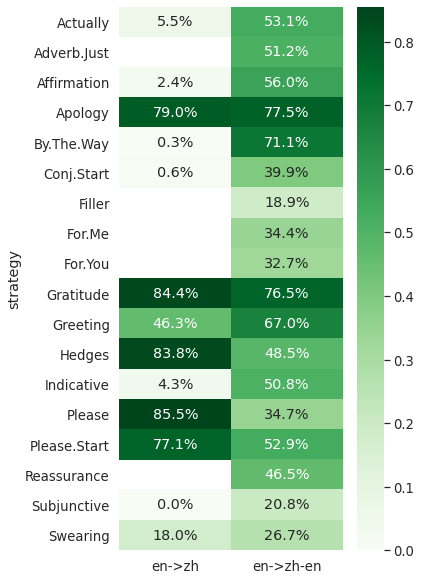

In [139]:
plt.figure(figsize=(5, 10))
sns.set(font_scale=1.2)

# cells that are not applicable are masked in white
with sns.axes_style("white"):
    sns.heatmap(permeability_df_en, annot=True, cmap="Greens", fmt=".1%", mask=permeability_df_en==-1)